In [1]:
import torch
import random
import pandas as pd
import pickle as pkl
from tqdm import tqdm
from os import listdir
from os.path import join
from random import shuffle
from transformers import AdamW
from matplotlib import pyplot as plt
from torch.nn import CrossEntropyLoss
from transformers import get_scheduler
from pdb import set_trace as breakpoint
from nltk.stem.snowball import SnowballStemmer
from torch.utils.data import Dataset, DataLoader
from transformers import BartTokenizer, BartForConditionalGeneration

In [2]:
%matplotlib inline

In [3]:
# folders = ['bags_and_cases', 'bluetooth', 'boots', 'keyboards', 'tv', 'vacuums']

# base_dir = '/mnt/nfs/work1/hongyu/brawat/amzn/oposum/data/seeds'

# list_aspects = []
# Aspect_to_seeds = {}
# stemmer = SnowballStemmer(language='english')
# for each_folder in folders:
#     folder_dir = join(base_dir, each_folder)
#     print('--'*20)
#     print(each_folder)
#     print('--'*20)
#     txt_files = listdir(folder_dir)
#     txt_files = [x for x in txt_files if 'None' not in x]
#     print(txt_files)
#     for each_txt in txt_files:
#         txt_dir = join(folder_dir, each_txt)
#         txt = open(txt_dir).read()
#         txt = txt.split('\n')
#         txt = [x.split(' ')[-1] for x in txt]
#         txt = [x.strip() for x in txt]
#         txt = [stemmer.stem(x) for x in txt]
#         aspect = each_txt.split('.')[1]
#         Aspect_to_seeds[aspect] = txt

In [4]:
# for each_aspect in Aspect_to_seeds:
#     print(each_aspect, Aspect_to_seeds[each_aspect].__len__())

In [5]:
# pkl.dump(Aspect_to_seeds, open('Aspect_to_seeds_march19.pkl', 'wb'))

In [6]:
Aspect_to_seeds = pkl.load(open('Aspect_to_seeds_march19.pkl', 'rb'))

In [7]:
for each_aspect in Aspect_to_seeds:
    Aspect_to_seeds[each_aspect] = [x for x in Aspect_to_seeds[each_aspect] if x.__len__()>0]

In [8]:
Aspect_to_seeds

{'Compartments': ['pocket',
  'cabl',
  'compart',
  'outsid',
  'lot',
  'wish',
  'wallet',
  'connector',
  'space',
  'power',
  'pen',
  'folder',
  'charger',
  'flap',
  'mous',
  'nice',
  'thing',
  'insid',
  'small',
  'paperwork',
  'accessori',
  'daytim',
  'jacket',
  'raincoat',
  'nois',
  'reduct',
  'earphon',
  'munchi',
  'construct',
  'medium',
  'player',
  'wire',
  'run',
  'headphon',
  'key',
  'instead',
  'huge',
  'need',
  'open',
  'fit',
  'headset',
  'outer',
  'planner',
  'safe',
  'adapt',
  'remot',
  'control',
  'cellphon',
  'save',
  'document'],
 'Price': ['price',
  'money',
  'feaur',
  'paid',
  'spin',
  'spun',
  'mayb',
  'cheap',
  '200',
  'spend',
  'right',
  'vaccum',
  'twice',
  'expect',
  'pricey',
  '50',
  'expens',
  'worth',
  'far',
  'wast',
  'duster',
  'think',
  'bagless',
  'best',
  'dyson',
  'need',
  'ok',
  'weight',
  'bag',
  'power',
  'light',
  'like',
  'good',
  'vacuum'],
 'Handles': ['strap',
  'handl'

In [9]:
for each_aspect in Aspect_to_seeds:
    print(each_aspect, Aspect_to_seeds[each_aspect].__len__())

Compartments 50
Price 34
Handles 50
Customer_service 50
Looks 22
Quality 50
Protection 49
Size_Fit 50
Ease_of_use 50
Sound 50
Look 50
Connectivity 50
Battery 48
Durability 50
Comfort 50
Materials 50
Color 19
Size 50
Weather_resistance 50
Noise 50
Extra_functionality 50
Layout 50
Feel_Comfort 50
Build_Quality 50
Size_Look 50
Image 50
Apps_Interface 47
Suction_Power 50
Weight 50
Customer_Service 48
Accessories 50


In [10]:
tokenizer = BartTokenizer.from_pretrained("facebook/bart-large-cnn")
# tokenizer = BartTokenizer.from_pretrained("facebook/bart-large")

In [11]:
# model = BartForConditionalGeneration.from_pretrained("facebook/bart-large")
model = BartForConditionalGeneration.from_pretrained("facebook/bart-large-cnn")

In [12]:
# !echo $CUDA_VISIBLE_DEVICES

In [13]:
model_args = {'seed_samples': 10, 
              'aspect_length':6
             }

In [14]:
class aspectDataset(Dataset):
    
    def __init__(self, list_data, tokenizer, model_args):
        self.tokenizer = tokenizer
        self.list_data = list_data
        self.seeds_length = model_args['seed_samples']
        self.aspect_length = model_args['aspect_length']
    
    def __len__(self):
        """Return length of dataset."""
        return self.list_data.__len__()

    def __getitem__(self, i):
        """Return sample from dataset at index i."""
        example = self.list_data[i]
        shuffle(example['seeds'])
        sampled_seeds = example['seeds'][:self.seeds_length]
        aspect = " ".join(example["aspect"].split('_'))
#         max_length = self.seeds_length+2
        inputs = tokenizer(", ".join(sampled_seeds), 
                           truncation=True)  
#         inputs = tokenizer(", ".join(sampled_seeds), 
#                            padding="max_length", 
#                            truncation=True, 
#                            max_length=max_length)  
        outputs = tokenizer(aspect, 
                            padding="max_length", 
                            truncation=True, 
                            max_length=self.aspect_length)
        
        batch = {}
        batch["input_ids"] = torch.LongTensor(inputs.input_ids)
        batch["attention_mask"] = torch.LongTensor(inputs.attention_mask)
#         batch["decoder_input_ids"] = torch.LongTensor(outputs.input_ids)
#         batch["decoder_attention_mask"] = torch.LongTensor(outputs.attention_mask)
        batch["labels"] = outputs.input_ids.copy()
        batch['labels'] = [batch['labels']]

        # We have to make sure that the PAD token is ignored for calculating the loss
        batch["labels"] = [[-100 if token == tokenizer.pad_token_id else token for token in labels] 
                           for labels in batch["labels"]]
        batch["labels"] = torch.LongTensor(batch["labels"])
        batch["labels"] = batch["labels"].squeeze(0)
        
        return batch

In [15]:
train_data = []
for each_key in Aspect_to_seeds:
    train_data.append({"seeds":Aspect_to_seeds[each_key],
                       "aspect":each_key})

In [16]:
train_dataset = aspectDataset(list_data=train_data, 
                              tokenizer=tokenizer,
                              model_args=model_args
                             )

In [17]:
train_loader = DataLoader(train_dataset, 
                          batch_size=1, 
                          shuffle=True,
                          num_workers=1)

In [18]:
model = model.to("cuda")

In [19]:
# the_encoder = model.get_encoder()
# the_decoder = model.get_decoder()
# last_linear_layer = model.lm_head

In [20]:
num_epochs = 15
num_training_steps = num_epochs * len(train_data)

loss_fct = CrossEntropyLoss()

optimizer = AdamW(model.parameters(), 
                  lr=2e-7)
warmup_steps = int(0.10*num_training_steps)
lr_scheduler = get_scheduler("linear",
                            optimizer=optimizer,
                            num_warmup_steps=warmup_steps,
                            num_training_steps=num_training_steps
                            )

In [21]:
all_train_loss = []
for epoch in tqdm(range(num_epochs)):
    training_loss = 0.0
    model.train()
    for ind, batch in enumerate(train_loader):
        batch = {k: v.to('cuda') for k, v in batch.items()}
        
        model_op = model(**batch)
        loss = model_op['loss']
        
        training_loss += loss.item()
        
        print('---'*20)
        print('Epoch:', epoch, 'ID:', ind)
        print('---'*20)
        print('Seed words:', tokenizer.batch_decode(batch['input_ids'], 
                                                    skip_special_tokens=True, 
                                                    clean_up_tokenization_spaces=False))
        print('Actual aspect:', tokenizer.batch_decode(batch['labels'][batch['labels']!=-100].unsqueeze(0), 
                                                       skip_special_tokens=True, 
                                                       clean_up_tokenization_spaces=True))
        output_ids = model.generate(batch["input_ids"], 
                                    num_beams=3, 
                                    max_length=6)
        print('Predicted aspect:', tokenizer.batch_decode(output_ids, 
                                                          skip_special_tokens=True, 
                                                          clean_up_tokenization_spaces=True))
        
        loss.backward()
        optimizer.step() 
        lr_scheduler.step() 
        optimizer.zero_grad() 
    training_loss = training_loss / len( train_data )
    all_train_loss.append(training_loss)
    print("Epoch {}:\tTraining Loss {:.2f}".format(epoch+1, training_loss))

  0%|          | 0/15 [00:00<?, ?it/s]

------------------------------------------------------------
Epoch: 0 ID: 0
------------------------------------------------------------
Seed words: ['perfect, consid, 60, fit, weigh, get, livingroom, anticip, huge, bedroom']
Actual aspect: ['Size Look']
Predicted aspect: ['perfect, cons']
------------------------------------------------------------
Epoch: 0 ID: 1
------------------------------------------------------------
Seed words: ['moment, littl, environ, foot, pain, super, perfect, minut, actual, put']
Actual aspect: ['Comfort']
Predicted aspect: ['moment,']
------------------------------------------------------------
Epoch: 0 ID: 2
------------------------------------------------------------
Seed words: ['direct, absolut, boot, degre, great, crazi, hang, super, concept, comfort']
Actual aspect: ['Look']
Predicted aspect: ['direct, abs']
------------------------------------------------------------
Epoch: 0 ID: 3
------------------------------------------------------------
Seed w

------------------------------------------------------------
Epoch: 0 ID: 29
------------------------------------------------------------
Seed words: ['time, horribl, phone, absolut, contact, mail, gotten, ignor, contact, look']
Actual aspect: ['Customer Service']
Predicted aspect: ['time, hor']
------------------------------------------------------------
Epoch: 0 ID: 30
------------------------------------------------------------
Seed words: ['attach, design, overheat, last, built, brush, swivel, barley, electron, break']
Actual aspect: ['Build Quality']
Predicted aspect: ['attach, design']


  7%|▋         | 1/15 [00:10<02:31, 10.84s/it]

Epoch 1:	Training Loss 7.00
------------------------------------------------------------
Epoch: 1 ID: 0
------------------------------------------------------------
Seed words: ['last, fail, burn, miss, snapper, overh, sturdi, barley, roller, 20']
Actual aspect: ['Build Quality']
Predicted aspect: ['last, fail']
------------------------------------------------------------
Epoch: 1 ID: 1
------------------------------------------------------------
Seed words: ['quieter, trebl, worthi, experi, strain, shippabl, bass, cheapest, muffl, kinda']
Actual aspect: ['Sound']
Predicted aspect: ['quieter,']
------------------------------------------------------------
Epoch: 1 ID: 2
------------------------------------------------------------
Seed words: ['alright, quit, interfac, access, friend, like, realli, samsung, applic, terribl']
Actual aspect: ['Apps Interface']
Predicted aspect: ['alright,']
------------------------------------------------------------
Epoch: 1 ID: 3
------------------------

------------------------------------------------------------
Epoch: 1 ID: 29
------------------------------------------------------------
Seed words: ['better, start, talk, simpl, meter, charger, hold, vari, stop, volum']
Actual aspect: ['Battery']
Predicted aspect: ['better, start']
------------------------------------------------------------
Epoch: 1 ID: 30
------------------------------------------------------------
Seed words: ['laptop, good, pad, comput, pencil, perfect, tast, weak, protect, pad']
Actual aspect: ['Protection']
Predicted aspect: ['laptop,']


 13%|█▎        | 2/15 [00:20<02:12, 10.21s/it]

Epoch 2:	Training Loss 6.47
------------------------------------------------------------
Epoch: 2 ID: 0
------------------------------------------------------------
Seed words: ['watch, eas, hulu, access, brows, user, capabl, comput, internet, right']
Actual aspect: ['Apps Interface']
Predicted aspect: ['watch,']
------------------------------------------------------------
Epoch: 2 ID: 1
------------------------------------------------------------
Seed words: ['laptop, bit, 13, size, enorm, accommod, dv7, tight, load, reduct']
Actual aspect: ['Size Fit']
Predicted aspect: ['Laptops']
------------------------------------------------------------
Epoch: 2 ID: 2
------------------------------------------------------------
Seed words: ['bright, hd, great, definit, imag, dvd, beauti, excel, decent, screen']
Actual aspect: ['Image']
Predicted aspect: ['The film is']
------------------------------------------------------------
Epoch: 2 ID: 3
----------------------------------------------------

------------------------------------------------------------
Epoch: 2 ID: 29
------------------------------------------------------------
Seed words: ['suction, floor, pick, unders, perform, ergorapido, produc, tile, perfom, power']
Actual aspect: ['Suction Power']
Predicted aspect: ['suction,']
------------------------------------------------------------
Epoch: 2 ID: 30
------------------------------------------------------------
Seed words: ['strap, item, edg, terribl, final, rip, excel, plastic, construct, wear']
Actual aspect: ['Quality']
Predicted aspect: ['strap, item']


 20%|██        | 3/15 [00:30<02:02, 10.17s/it]

Epoch 3:	Training Loss 5.99
------------------------------------------------------------
Epoch: 3 ID: 0
------------------------------------------------------------
Seed words: ['probabl, consid, lightweight, area, thought, compar, heavi, purchas, vaccuum, canist']
Actual aspect: ['Weight']
Predicted aspect: ['Probabl']
------------------------------------------------------------
Epoch: 3 ID: 1
------------------------------------------------------------
Seed words: ['look, nice, pc, small, great, beauti, imac, good, cheap, laptop']
Actual aspect: ['Looks']
Predicted aspect: ['look, nice']
------------------------------------------------------------
Epoch: 3 ID: 2
------------------------------------------------------------
Seed words: ['sharp, eye, look, crisp, notic, affect, level, inch, ear, dead']
Actual aspect: ['Image']
Predicted aspect: ['sharp, eye']
------------------------------------------------------------
Epoch: 3 ID: 3
-----------------------------------------------------

------------------------------------------------------------
Epoch: 3 ID: 29
------------------------------------------------------------
Seed words: ['design, taup, red, materi, look, wonder, love, love, favorit, exact']
Actual aspect: ['Color']
Predicted aspect: ['design, t']
------------------------------------------------------------
Epoch: 3 ID: 30
------------------------------------------------------------
Seed words: ['develop, true, good, weird, great, ear, display, bar, loudest, speaker']
Actual aspect: ['Sound']
Predicted aspect: ['develop, true']


 27%|██▋       | 4/15 [00:40<01:51, 10.16s/it]

Epoch 4:	Training Loss 5.73
------------------------------------------------------------
Epoch: 4 ID: 0
------------------------------------------------------------
Seed words: ['stick, tap, relax, velvet, type, level, smooth, stylish, butteri, navig']
Actual aspect: ['Feel Comfort']
Predicted aspect: ['stick, tap']
------------------------------------------------------------
Epoch: 4 ID: 1
------------------------------------------------------------
Seed words: ['put, discomfort, tongu, actual, list, abl, insid, offic, short, blister']
Actual aspect: ['Comfort']
Predicted aspect: ['put, discomfort']
------------------------------------------------------------
Epoch: 4 ID: 2
------------------------------------------------------------
Seed words: ['thought, purchas, compact, compar, power, suppos, minor, nice, price, maneuv']
Actual aspect: ['Weight']
Predicted aspect: ['thought, purch']
------------------------------------------------------------
Epoch: 4 ID: 3
-----------------------

------------------------------------------------------------
Epoch: 4 ID: 29
------------------------------------------------------------
Seed words: ['perform, repel, warm, lot, snow, wet, francisco, resist, alcatraz, defect']
Actual aspect: ['Weather resistance']
Predicted aspect: ['The word "']
------------------------------------------------------------
Epoch: 4 ID: 30
------------------------------------------------------------
Seed words: ['calm, good, super, love, smooth, fring, concept, look, pictur, weight']
Actual aspect: ['Look']
Predicted aspect: ['calm,']


 33%|███▎      | 5/15 [00:51<01:42, 10.23s/it]

Epoch 5:	Training Loss 5.41
------------------------------------------------------------
Epoch: 5 ID: 0
------------------------------------------------------------
Seed words: ['hide, compar, quiet, explod, incred, doggi, direct, size, readi, weight']
Actual aspect: ['Noise']
Predicted aspect: ['hide, compar']
------------------------------------------------------------
Epoch: 5 ID: 1
------------------------------------------------------------
Seed words: ['reach, hardwood, wide, wonder, bag, extra, requir, sensor, filter, roll']
Actual aspect: ['Accessories']
Predicted aspect: ['reach, hard']
------------------------------------------------------------
Epoch: 5 ID: 2
------------------------------------------------------------
Seed words: ['perfect, feel, action, finger, quick, difficult, like, signatur, type, satisfi']
Actual aspect: ['Feel Comfort']
Predicted aspect: ['perfect, feel']
------------------------------------------------------------
Epoch: 5 ID: 3
---------------------

------------------------------------------------------------
Epoch: 5 ID: 29
------------------------------------------------------------
Seed words: ['carpet, ok, pick, floor, spin, tile, suction, ergorapido, hair, main']
Actual aspect: ['Suction Power']
Predicted aspect: ['Carpet']
------------------------------------------------------------
Epoch: 5 ID: 30
------------------------------------------------------------
Seed words: ['nice, custom, activ, vista, mute, remain, sleep, illumin, special, quit']
Actual aspect: ['Extra functionality']
Predicted aspect: ['nice, custom']


 40%|████      | 6/15 [01:01<01:32, 10.31s/it]

Epoch 6:	Training Loss 5.03
------------------------------------------------------------
Epoch: 6 ID: 0
------------------------------------------------------------
Seed words: ['short, lift, wear, attach, rip, sooner, bend, tear, minut, inevit']
Actual aspect: ['Handles']
Predicted aspect: ['short, lift']
------------------------------------------------------------
Epoch: 6 ID: 1
------------------------------------------------------------
Seed words: ['unannounc, constuct, flimsi, snapper, fail, fifth, last, swivel, bump, continu']
Actual aspect: ['Build Quality']
Predicted aspect: ['unannoun']
------------------------------------------------------------
Epoch: 6 ID: 2
------------------------------------------------------------
Seed words: ['ergorapido, power, produc, stylish, perfom, spot, simpic, essenti, machin, floor']
Actual aspect: ['Suction Power']
Predicted aspect: ['The most popular']
------------------------------------------------------------
Epoch: 6 ID: 3
--------------

------------------------------------------------------------
Epoch: 6 ID: 29
------------------------------------------------------------
Seed words: ['francisco, cold, traction, suppos, soak, den, repel, generous, stay, perform']
Actual aspect: ['Weather resistance']
Predicted aspect: ['Francisco']
------------------------------------------------------------
Epoch: 6 ID: 30
------------------------------------------------------------
Seed words: ['hdmi, higher, dhcp, enabl, digit, comcast, stream, file, end, signal']
Actual aspect: ['Connectivity']
Predicted aspect: ['hdmi,']


 47%|████▋     | 7/15 [01:12<01:22, 10.33s/it]

Epoch 7:	Training Loss 4.76
------------------------------------------------------------
Epoch: 7 ID: 0
------------------------------------------------------------
Seed words: ['good, 200, spend, wast, power, think, need, vaccum, light, best']
Actual aspect: ['Price']
Predicted aspect: ['good, 200']
------------------------------------------------------------
Epoch: 7 ID: 1
------------------------------------------------------------
Seed words: ['materi, style, long, pretti, cheapli, abl, deflat, time, qualiti, cheep']
Actual aspect: ['Durability']
Predicted aspect: ['Materi']
------------------------------------------------------------
Epoch: 7 ID: 2
------------------------------------------------------------
Seed words: ['especi, quiet, loud, compar, carri, light, area, vaccuum, ok, maneuv']
Actual aspect: ['Weight']
Predicted aspect: ['especi']
------------------------------------------------------------
Epoch: 7 ID: 3
------------------------------------------------------------


------------------------------------------------------------
Epoch: 7 ID: 29
------------------------------------------------------------
Seed words: ['recommend, function, hide, light, direct, earplug, serious, pro, peopl, lose']
Actual aspect: ['Noise']
Predicted aspect: ['The "']
------------------------------------------------------------
Epoch: 7 ID: 30
------------------------------------------------------------
Seed words: ['hose, wide, crevic, extens, get, green, filter, clean, okay, extra']
Actual aspect: ['Accessories']
Predicted aspect: ['hose,']


 53%|█████▎    | 8/15 [01:22<01:12, 10.33s/it]

Epoch 8:	Training Loss 4.51
------------------------------------------------------------
Epoch: 8 ID: 0
------------------------------------------------------------
Seed words: ['realli, ear, loudest, strong, cool, develop, true, hear, track, terribl']
Actual aspect: ['Sound']
Predicted aspect: ['realli,']
------------------------------------------------------------
Epoch: 8 ID: 1
------------------------------------------------------------
Seed words: ['hubbi, fuzzi, nice, level, definit, dead, pixel, sharp, caus, black']
Actual aspect: ['Image']
Predicted aspect: ['hubbi']
------------------------------------------------------------
Epoch: 8 ID: 2
------------------------------------------------------------
Seed words: ['overheat, upper, design, smell, simpli, burnt, poor, 20, fail, connect']
Actual aspect: ['Build Quality']
Predicted aspect: ['Design,']
------------------------------------------------------------
Epoch: 8 ID: 3
-------------------------------------------------------

------------------------------------------------------------
Epoch: 8 ID: 29
------------------------------------------------------------
Seed words: ['clean, way, attach, empti, scrap, allow, easili, eye, reach, requir']
Actual aspect: ['Accessories']
Predicted aspect: ['clean, way']
------------------------------------------------------------
Epoch: 8 ID: 30
------------------------------------------------------------
Seed words: ['dlna, connect, hd, min, internet, integr, power, comput, netflix, fi']
Actual aspect: ['Connectivity']
Predicted aspect: ['The new Netflix']


 60%|██████    | 9/15 [01:32<01:02, 10.37s/it]

Epoch 9:	Training Loss 4.21
------------------------------------------------------------
Epoch: 9 ID: 0
------------------------------------------------------------
Seed words: ['standard, conflict, comcast, 45, slot, stop, compon, netflix, cabl, wi']
Actual aspect: ['Connectivity']
Predicted aspect: ['Cinema']
------------------------------------------------------------
Epoch: 9 ID: 1
------------------------------------------------------------
Seed words: ['pretti, heavi, obvious, month, deflat, qualiti, barn, use, daili, collaps']
Actual aspect: ['Durability']
Predicted aspect: ['The month of']
------------------------------------------------------------
Epoch: 9 ID: 2
------------------------------------------------------------
Seed words: ['good, tile, object, main, grout, fair, superb, filter, leav, total']
Actual aspect: ['Suction Power']
Predicted aspect: ['good, tile']
------------------------------------------------------------
Epoch: 9 ID: 3
---------------------------------

------------------------------------------------------------
Epoch: 9 ID: 29
------------------------------------------------------------
Seed words: ['small, activ, bigger, scroll, million, movement, end, delet, close, home']
Actual aspect: ['Layout']
Predicted aspect: ['small, activ']
------------------------------------------------------------
Epoch: 9 ID: 30
------------------------------------------------------------
Seed words: ['synthet, calm, aerosol, smooth, rubber, foam, finish, cloth, advertis, direct']
Actual aspect: ['Materials']
Predicted aspect: ['Synthet']


 67%|██████▋   | 10/15 [01:43<00:52, 10.50s/it]

Epoch 10:	Training Loss 4.15
------------------------------------------------------------
Epoch: 10 ID: 0
------------------------------------------------------------
Seed words: ['pound, home, foot, suitabl, weigh, bigger, weigh, slim, size, 3d']
Actual aspect: ['Size Look']
Predicted aspect: ['pound, home']
------------------------------------------------------------
Epoch: 10 ID: 1
------------------------------------------------------------
Seed words: ['vertic, proof, spill, tini, close, label, space, million, chang, paus']
Actual aspect: ['Layout']
Predicted aspect: ['vertic,']
------------------------------------------------------------
Epoch: 10 ID: 2
------------------------------------------------------------
Seed words: ['contact, contact, absolut, took, card, recent, video, lubric, respons, warranti']
Actual aspect: ['Customer Service']
Predicted aspect: ['This article includes']
------------------------------------------------------------
Epoch: 10 ID: 3
------------------

------------------------------------------------------------
Epoch: 10 ID: 29
------------------------------------------------------------
Seed words: ['wet, sandal, claim, cub, foot, san, alcatraz, defect, step, ice']
Actual aspect: ['Weather resistance']
Predicted aspect: ['wet,']
------------------------------------------------------------
Epoch: 10 ID: 30
------------------------------------------------------------
Seed words: ['abl, light, comfort, ankl, loos, doc, actual, walk, enjoy, tongu']
Actual aspect: ['Comfort']
Predicted aspect: ['. The']


 73%|███████▎  | 11/15 [01:53<00:41, 10.40s/it]

Epoch 11:	Training Loss 3.91
------------------------------------------------------------
Epoch: 11 ID: 0
------------------------------------------------------------
Seed words: ['hurt, shoulder, rip, felt, broken, break, wear, long, lift, adapt']
Actual aspect: ['Handles']
Predicted aspect: ['hurt,']
------------------------------------------------------------
Epoch: 11 ID: 1
------------------------------------------------------------
Seed words: ['rug, vaccuum, light, histori, perform, nice, cumbersom, suppos, especi, panason']
Actual aspect: ['Weight']
Predicted aspect: ['rug, vacc']
------------------------------------------------------------
Epoch: 11 ID: 2
------------------------------------------------------------
Seed words: ['backlit, beauti, longer, slim, laptop, appear, nice, imac, like, keyboard']
Actual aspect: ['Looks']
Predicted aspect: ['Backlit keyboard']
------------------------------------------------------------
Epoch: 11 ID: 3
-----------------------------------

------------------------------------------------------------
Epoch: 11 ID: 29
------------------------------------------------------------
Seed words: ['filter, attribut, good, reason, grout, dirt, simpic, object, vacuum, spin']
Actual aspect: ['Suction Power']
Predicted aspect: [' filter, attribut']
------------------------------------------------------------
Epoch: 11 ID: 30
------------------------------------------------------------
Seed words: ['connector, safe, key, run, construct, space, headphon, nice, thing, outer']
Actual aspect: ['Compartments']
Predicted aspect: ['connector,']


 80%|████████  | 12/15 [02:04<00:31, 10.36s/it]

Epoch 12:	Training Loss 4.01
------------------------------------------------------------
Epoch: 12 ID: 0
------------------------------------------------------------
Seed words: ['recent, warranti, lubric, unfortun, contact, custom, card, day, respond, issu']
Actual aspect: ['Customer Service']
Predicted aspect: ['A look at']
------------------------------------------------------------
Epoch: 12 ID: 1
------------------------------------------------------------
Seed words: ['perfect, respond, impecc, sens, action, quick, ibm, type, membran, like']
Actual aspect: ['Feel Comfort']
Predicted aspect: ['perfect, respond']
------------------------------------------------------------
Epoch: 12 ID: 2
------------------------------------------------------------
Seed words: ['deafen, loudest, pro, purchas, weight, light, direct, power, compar, hide']
Actual aspect: ['Noise']
Predicted aspect: ['Deafen']
------------------------------------------------------------
Epoch: 12 ID: 3
---------------

------------------------------------------------------------
Epoch: 12 ID: 29
------------------------------------------------------------
Seed words: ['interest, program, brower, shortcut, legibl, spillproof, light, nice, email, dim']
Actual aspect: ['Extra functionality']
Predicted aspect: ['Programs are']
------------------------------------------------------------
Epoch: 12 ID: 30
------------------------------------------------------------
Seed words: ['spend, light, 200, dyson, mayb, good, duster, ok, spin, wast']
Actual aspect: ['Price']
Predicted aspect: ['Spend,']


 87%|████████▋ | 13/15 [02:13<00:20, 10.22s/it]

Epoch 13:	Training Loss 4.05
------------------------------------------------------------
Epoch: 13 ID: 0
------------------------------------------------------------
Seed words: ['perfect, inch, nois, earphon, folder, 13, laptop, m1710, perfect, munchi']
Actual aspect: ['Size Fit']
Predicted aspect: ['Munchi']
------------------------------------------------------------
Epoch: 13 ID: 1
------------------------------------------------------------
Seed words: ['matrix, get, ultra, screen, inch, oh, hardwar, compact, wonder, big']
Actual aspect: ['Size Look']
Predicted aspect: ['Matrix is']
------------------------------------------------------------
Epoch: 13 ID: 2
------------------------------------------------------------
Seed words: ['protect, thing, damag, pad, drop, larg, bag, comput, realli, like']
Actual aspect: ['Protection']
Predicted aspect: ['protect, thing']
------------------------------------------------------------
Epoch: 13 ID: 3
----------------------------------------

------------------------------------------------------------
Epoch: 13 ID: 29
------------------------------------------------------------
Seed words: ['hose, easi, easier, power, awkward, disassembl, imposs, eas, person, jump']
Actual aspect: ['Ease of use']
Predicted aspect: ['Easily']
------------------------------------------------------------
Epoch: 13 ID: 30
------------------------------------------------------------
Seed words: ['help, arriv, 100lb, clear, come, undamag, later, support, use, divx']
Actual aspect: ['Customer service']
Predicted aspect: ['Help, arri']


 93%|█████████▎| 14/15 [02:24<00:10, 10.23s/it]

Epoch 14:	Training Loss 3.84
------------------------------------------------------------
Epoch: 14 ID: 0
------------------------------------------------------------
Seed words: ['wake, bright, pencil, dark, dim, email, volum, illumin, remain, multimedia']
Actual aspect: ['Extra functionality']
Predicted aspect: ['Wake']
------------------------------------------------------------
Epoch: 14 ID: 1
------------------------------------------------------------
Seed words: ['pictur, look, bright, expeci, color, biggest, right, pixel, dvd, black']
Actual aspect: ['Image']
Predicted aspect: ['Pictur,']
------------------------------------------------------------
Epoch: 14 ID: 2
------------------------------------------------------------
Seed words: ['explod, ring, hide, nozzl, ear, nois, silent, incred, actual, turn']
Actual aspect: ['Noise']
Predicted aspect: ['explod,']
------------------------------------------------------------
Epoch: 14 ID: 3
-------------------------------------------

------------------------------------------------------------
Epoch: 14 ID: 29
------------------------------------------------------------
Seed words: ['fashion, cloth, buckl, thinner, superb, barn, come, materi, natur, synthet']
Actual aspect: ['Materials']
Predicted aspect: ['The']
------------------------------------------------------------
Epoch: 14 ID: 30
------------------------------------------------------------
Seed words: ['pretti, mayb, good, ergorapido, bear, floor, vacuum, dosen, power, realli']
Actual aspect: ['Suction Power']
Predicted aspect: ['pretti,']


100%|██████████| 15/15 [02:35<00:00, 10.34s/it]

Epoch 15:	Training Loss 3.58


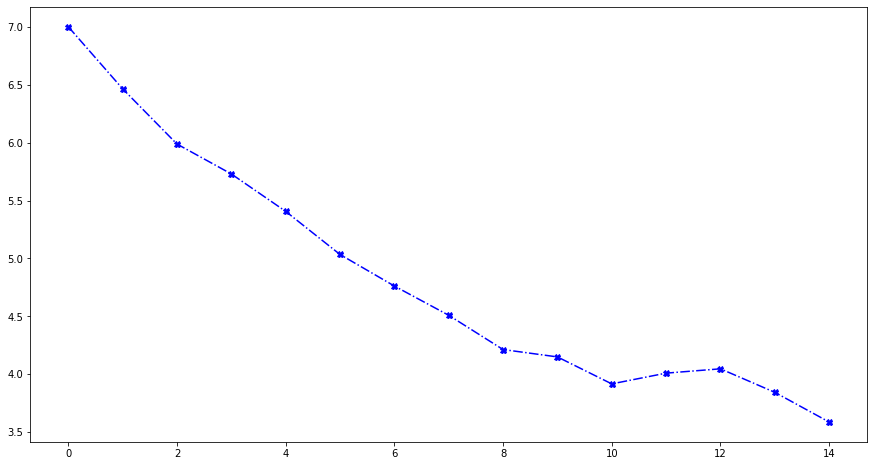

In [22]:
plt.rcParams["figure.figsize"] = (15,8)
plt.plot(all_train_loss, ls='-.', marker = 'X', color='blue')

In [23]:
stop_

NameError: name 'stop_' is not defined

### Generation for the topics of CTM
--------------------------------------------

In [24]:
electronic_topics = open('electronics_40_topics').read()
electronic_topics = electronic_topics.split('\n')

electronic_topics = [x for ind, x in enumerate(electronic_topics) if ind%2==0]

electronic_topics = [x.replace("'", "") for x in electronic_topics]
electronic_topics = [x.replace("[", "") for x in electronic_topics]
electronic_topics = [x.replace("]", "") for x in electronic_topics]
electronic_topics = [x.replace(",", "") for x in electronic_topics]
electronic_topics = [x.split(' ')[1:] for x in electronic_topics]

In [25]:
stemmer = SnowballStemmer(language='english')

In [26]:
stemmed_electronic_topics = []
for each_topic in electronic_topics:
    tmp_ = [stemmer.stem(x) for x in each_topic]
    stemmed_electronic_topics.append(tmp_)

In [27]:
model_args['seed_samples']

10

In [28]:
model.eval()
for each_topic in stemmed_electronic_topics:
    topic_seeds = each_topic[:model_args['seed_samples']]
    in_tokenized = tokenizer(', '.join(topic_seeds), 
                             truncation=True)  
    in_ids = torch.LongTensor(in_tokenized.input_ids)
    in_ids = in_ids.to('cuda')
    in_ids = in_ids.unsqueeze(0)
    op_ids = model.generate(in_ids, 
                            num_beams=3, 
                            max_length=6)
    print('Seeds:', topic_seeds)
    print('Predicted aspect:', tokenizer.batch_decode(op_ids, 
                                                      skip_special_tokens=True, 
                                                      clean_up_tokenization_spaces=True))
    print('--'*30)

Seeds: ['construct', 'valu', 'exceed', 'outstand', 'light', 'weight', 'attract', 'versatil', 'excel', 'valu']
Predicted aspect: ['The']
------------------------------------------------------------
Seeds: ['deck', 'patio', 'beach', 'loud', 'camp', 'parti', 'hous', 'everywh', 'portabl', 'backyard']
Predicted aspect: ['The']
------------------------------------------------------------
Seeds: ['pick', 'channel', 'local', 'live', 'signal', 'station', 'abl', 'pick', 'recept', 'citi']
Predicted aspect: ['Pick']
------------------------------------------------------------
Seeds: ['instal', 'wall', 'inch', 'hung', 'mount', 'sturdi', 'articul', 'hardwar', 'motion', 'vizio']
Predicted aspect: ['Instal']
------------------------------------------------------------
Seeds: ['dac', 'pono', 'listen', 'fiio', 'amp', 'hi', 'audio', 'iem', 'hi', 'res']
Predicted aspect: ['.com']
------------------------------------------------------------
Seeds: ['usb', 'outlet', 'adapt', 'travel', 'prong', 'usb', 'port'

In [1]:
import pickle as pkl
Aspect_to_seeds = pkl.load(open('Aspect_to_seeds_march19.pkl', 'rb'))
# Aspect_to_seeds.keys()
# [x for x in Aspect_to_seeds if 'weather' in x.lower()]

In [ ]:
[x for x in Aspect_to_seeds if 'weather' in x.lower()]

In [ ]:
#         """Return sample from dataset at index i."""
#         example = self.list_data[i]
#         shuffle(example['seeds'])
#         sampled_seeds = example['seeds'][:self.seeds_length]
#         aspect = " ".join(example["aspect"].split('_'))
#         inputs = tokenizer(", ".join(sampled_seeds), 
#                            truncation=True)  
#         outputs = tokenizer(aspect, 
#                             padding="max_length", 
#                             truncation=True, 
#                             max_length=self.aspect_length)
        
#         batch = {}
#         batch["input_ids"] = torch.LongTensor(inputs.input_ids)
#         batch["attention_mask"] = torch.LongTensor(inputs.attention_mask)
#         batch["labels"] = outputs.input_ids.copy()
#         batch['labels'] = [batch['labels']]

#         batch["labels"] = [[-100 if token == tokenizer.pad_token_id else token for token in labels] 
#                            for labels in batch["labels"]]
#         batch["labels"] = torch.LongTensor(batch["labels"])
#         batch["labels"] = batch["labels"].squeeze(0)
        
#         return batch

In [ ]:
# chk_1 =tokenizer('MaterialsComp', 
#           padding="max_length", 
#           truncation=True, 
#           max_length=6)

In [ ]:
# tokenizer.batch_decode(chk_1['input_ids'], skip_special_tokens=True, clean_up_tokenization_spaces=False)

In [ ]:
# chk_2 =tokenizer('Ease of use', 
#           padding="max_length", 
#           truncation=True, 
#           max_length=6)

In [ ]:
# tokenizer.batch_decode(chk_2['input_ids'], skip_special_tokens=True, clean_up_tokenization_spaces=False)

In [ ]:
# chk_ = tokenizer('Compartments', 
#           padding="max_length", 
#           truncation=True, 
#           max_length=4)

In [ ]:
# tokenizer.batch_decode(chk_['input_ids'], 
#                        skip_special_tokens=True, 
#                        clean_up_tokenization_spaces=False)

In [ ]:
electronic_topics = open('electronics_40_topics').read()
electronic_topics = electronic_topics.split('\n')

electronic_topics = [x for ind, x in enumerate(electronic_topics) if ind%2==0]

electronic_topics = [x.replace("'", "") for x in electronic_topics]
electronic_topics = [x.replace("[", "") for x in electronic_topics]
electronic_topics = [x.replace("]", "") for x in electronic_topics]
electronic_topics = [x.replace(",", "") for x in electronic_topics]
electronic_topics = [x.split(' ')[1:] for x in electronic_topics]

In [ ]:
electronic_topics = [x[:20] for x in electronic_topics]

In [ ]:
test_data = []
for each_e_top in electronic_topics:
    test_data.append({'seeds': each_e_top[:20], 'aspect':'TestSet'})

In [ ]:
test_dataset = aspectDataset(list_data=test_data, 
                              tokenizer=tokenizer)

In [ ]:
test_loader = DataLoader(test_dataset, 
                         batch_size=1, 
                         shuffle=True,
                         num_workers=1)

In [ ]:
model.eval()
for ind, batch in enumerate(test_loader):
    batch = {k: v.to('cuda') for k, v in batch.items()}
    model_op = model(**batch)
    print('---'*20)
    print('ID:', ind)
    print('---'*20)
    print('Seed words:', tokenizer.batch_decode(batch['input_ids'], skip_special_tokens=True, clean_up_tokenization_spaces=False))
    print('Actual aspect:', tokenizer.batch_decode(batch['decoder_input_ids'], skip_special_tokens=True, clean_up_tokenization_spaces=False))
    output_ids = model.generate(batch["input_ids"], num_beams=3, max_length=6)
    print('Predicted aspect:', tokenizer.batch_decode(output_ids, skip_special_tokens=True, clean_up_tokenization_spaces=True))

In [ ]:
model_op['logits'].squeeze(dim=0).shape

In [ ]:
torch.argmax(model_op['logits'].squeeze(dim=0), dim=1)

## Orphan Code
-------------

In [ ]:
print(another_way_to_train)
for epoch in range(num_epochs):
    training_loss = 0.0
    model.train()
    for batch in tqdm(train_loader):
        batch = {k: v.to('cuda') for k, v in batch.items()}
        
        # Get the "input's representation"
        encoder_output = the_encoder(input_ids = batch['input_ids'],
                                   attention_mask = batch['attention_mask'])
      
        # Pass the representation + the target summary to the decoder
        decoder_output = the_decoder(input_ids=batch['decoder_input_ids'],
                                   attention_mask=batch['decoder_attention_mask'],
                                   encoder_hidden_states=encoder_output[0],
                                   encoder_attention_mask=batch['attention_mask'])

        # Use the last linear layer to predict the next token
        decoder_output = decoder_output.last_hidden_state
        lm_head_output = last_linear_layer(decoder_output)
        
        # Compute the loss
        loss = loss_fct(lm_head_output.view(-1, model.config.vocab_size),
                      batch['labels'].view(-1))
        training_loss += loss.item()
        
        loss.backward() # Update the weights
        optimizer.step() # Notify optimizer that a batch is done.
        lr_scheduler.step() # Notify the scheduler that a ...
        optimizer.zero_grad() # Reset the optimer
    training_loss = training_loss / len( train_data )
    print("Epoch {}:\tTraining Loss {:.2f}".format(epoch+1, training_loss))

In [ ]:
lm_head_output.view(-1, model.config.vocab_size)